# Generating Model Flux Arrays

The data to recreate the best galaxy, star, and QSO models for a given fiber's flux information can be found by using information in the spZall fits file for a plate and several eigen spectra fits files that come with the IDLSPEC2D package from SDSS. This notebook uses the fitsio, bossdata, and speclite packages to generate models.

In [1]:
import bossdata
import fitsio
import speclite
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
finder = bossdata.path.Finder()
mirror = bossdata.remote.Manager()
temp_folder = mirror.local_path('BOSS_templates')
obj_data = bossdata.meta.Database()

In [194]:
def make_model(plate, mjd, fiber, wlen, num = 1):
    """
    Return numpy structured array of flux for model
    
    Args:
        plate(int): plate number (must be valid plate number)
        mjd(ind): Modified Julian Date of observation for given plate
        fiber(int): fiber number of object to model
        wlen(np.array): wavelength array for given fiber
        num(int): integer between 1 and 134 (inclusive) denoting which model to generate.
            1 denotes best fit, 2 denotes second best, etc.
    
    Returns:
        model(np.array): numpy structured array of the same length as wlen with flux of model
    """
    LENGTH = 10000
    GAL_L = 10000
#Acquire data from spZall file
    remote = '/sas/dr12/boss/spectro/redux/v5_7_0/{0}/v5_7_0/spZall-{0}-{1}.fits'
    local = mirror.get(remote.format(plate, mjd))
    Z_all = fitsio.FITS(local)
    Z_info = Z_all[1]['Z','TFILE','TCOLUMN','NPOLY','THETA'][(fiber-1)*134 + num - 1]
    Z_all.close()

#Acquire data from file with eigenspectra
    template_file = Z_info['TFILE'][0].strip()
    num_col = np.argmin(Z_info['TCOLUMN'])
    template_fits = fitsio.FITS('{}/{}'.format(mirror.local_path('BOSS_templates'),template_file))
    header = template_fits[0].read_header()
    eigen_spectra = template_fits[0][:,:]
    template_fits.close()
    
#Add eigenspectra with respective coefficients
    flux = np.zeros(len(eigen_spectra[0]), dtype =[('flux','float32')])
    for i in range(num_col):
        flux['flux'][:] = flux['flux'] + Z_info['THETA'][0][i] * eigen_spectra[Z_info['TCOLUMN'][0][i]]
#Create unshifted loglam array
    index = np.arange(len(flux['flux']), dtype= 'float32')
    index = index * header['COEFF1']
#Create polynomial array and resample it
    index2 = np.arange(LENGTH, dtype= 'float32')
    index2 = index2 * header['COEFF1']
    poly = np.zeros(LENGTH, dtype = [('poly','float32')])
    for j in range(Z_info[0]['NPOLY']):
        poly['poly'] = poly['poly'] + np.power(index2,j) * Z_info[0]['THETA'][num_col + j]
    poly2 = speclite.resample(poly, np.linspace(0, len(flux['flux']), num = LENGTH)*header['COEFF1'], index, ('poly'))
#Shift loglam array
    index = index + header['COEFF0']
#Add polynomial to eigenspectra flux
    flux['flux'][:] = flux['flux'] + poly2['poly']
    
#Redshift model wavelength array (10 ^ loglam array) and resample flux
    rs_wlen = speclite.redshift(0, Z_info[0]['Z'],rules=[dict(name='wlen', exponent=+1, array_in = 10**index)])
    model = speclite.resample(flux , rs_wlen['wlen'].astype('float32'), wlen, ('flux'))
    
    return model['flux']

In [178]:
p = 4053
m = 55591
f = 6

To get the wavelength array, use bossdata. For the purposes of comparison, taking the best fit model array from the spec file will allow for plotting both versions of the best fit model.

In [179]:
remote_path = finder.get_spec_path(plate=p, mjd=m, fiber=f, lite=True)
local_path = mirror.get(remote_path)
info = bossdata.spec.SpecFile(local_path)
data = info.get_valid_data()
wlen, flux, dflux = data['wavelength'][:], data['flux'][:], data['dflux'][:]
model = info.hdulist[1]['model'][:]

In [180]:
test_model = make_model(p, m, f, wlen)

First test subject looks decent. The model seems to fit the object's spectrum, but there is a slight deviation from the model flux array that is given in the object's speclite file.

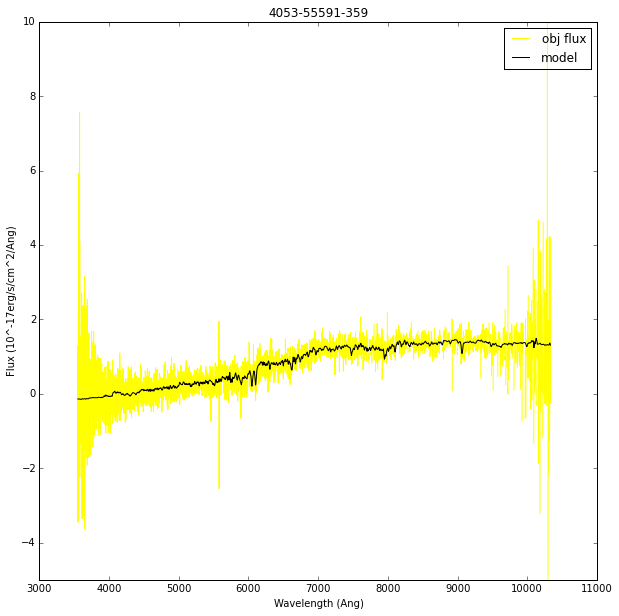

In [123]:
plt.figure(figsize = (10,10))
plt.plot(wlen, flux, color = 'yellow', label = 'obj flux')
plt.plot(wlen, test_model, color = 'black', label = 'model')
plt.title('{}-{}-{}'.format(p, m, f))
plt.legend()
plt.xlabel('Wavelength (Ang)')
plt.ylabel('Flux (10^-17erg/s/cm^2/Ang)')
plt.ylim((-5,10))
plt.show()

With LENGTH = 10000

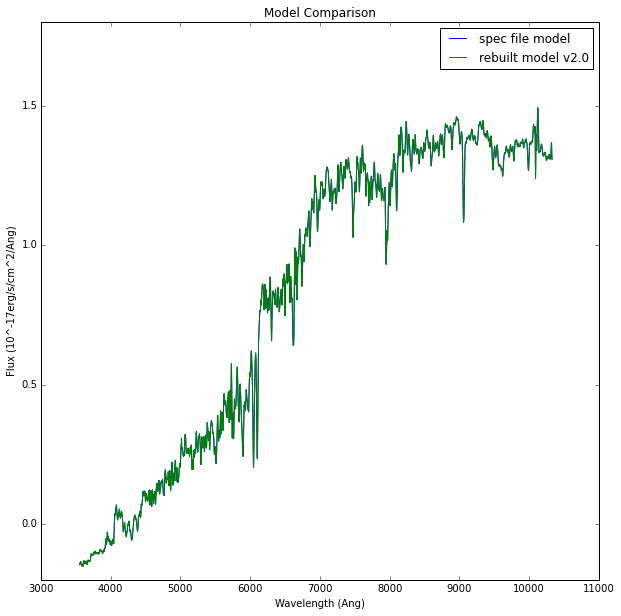

In [125]:
plt.figure(figsize = (10,10))
plt.plot(wlen, model, label = 'spec file model')
plt.plot(wlen, test_model, label = 'rebuilt model v2.0')
plt.ylim((-0.2,1.8))
plt.title('Model Comparison')
plt.legend()
plt.xlabel('Wavelength (Ang)')
plt.ylabel('Flux (10^-17erg/s/cm^2/Ang)')
plt.show()

The difference between my generated model and the speclite file's model seems to be quadratic

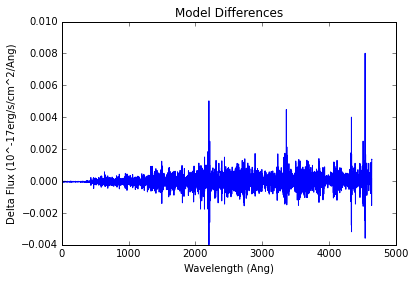

In [126]:
plt.plot(test_model-model)
plt.title('Model Differences')
plt.xlabel('Wavelength (Ang)')
plt.ylabel('Delta Flux (10^-17erg/s/cm^2/Ang)')
plt.show()

Finding more test subjects in the same plate (to avoid downloading another spZall file) with different classes

In [72]:
obj_data.select_all(what = 'FIBER,Z,CLASS,OBJTYPE', where = 'PLATE == 4053', max_rows = 10)

FIBER,Z,CLASS,OBJTYPE
int64,float64,string48,string128
1,0.56605,GALAXY,GALAXY
2,0.48335,QSO,SKY
3,0.52887,GALAXY,GALAXY
4,0.38076,GALAXY,GALAXY
5,0.5523,GALAXY,GALAXY
6,0.000708,STAR,SPECTROPHOTO_STD
7,0.42641,QSO,GALAXY
8,0.00030521,STAR,QSO
9,0.29088,GALAXY,GALAXY


Testing against a spectrophotometric standard star shows that in cases with larger model flux values, the difference between my generated model and the speclite model is exacerbated. In this case, my model does not at all fit the object's flux.

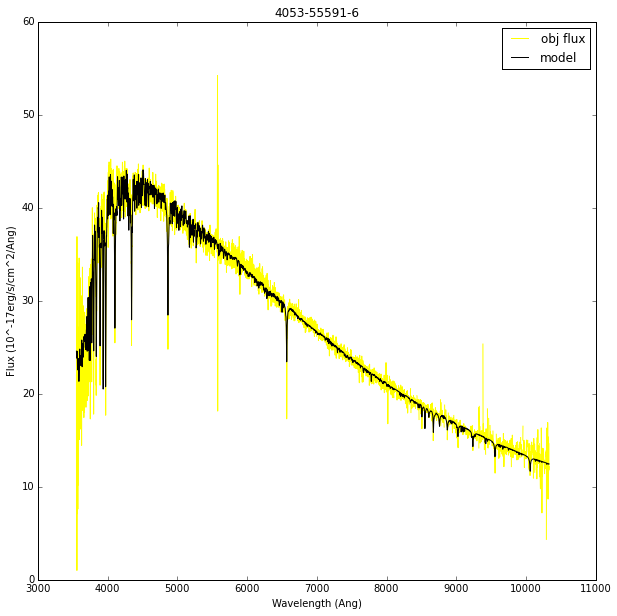

In [195]:
plt.figure(figsize = (10,10))
plt.plot(wlen, flux, color = 'yellow', label = 'obj flux')
plt.plot(wlen, test_model, color = 'black', label = 'model')
plt.title('{}-{}-{}'.format(p, m, f))
plt.legend()
plt.xlabel('Wavelength (Ang)')
plt.ylabel('Flux (10^-17erg/s/cm^2/Ang)')
plt.show()

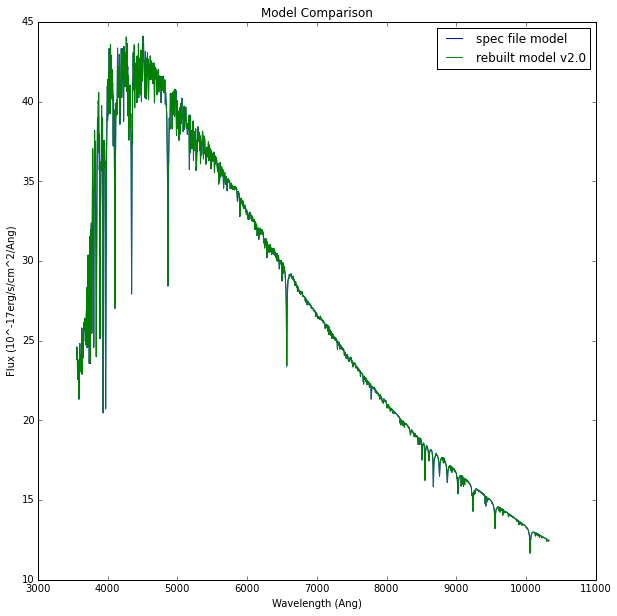

In [196]:
plt.figure(figsize = (10,10))
plt.plot(wlen, model, label = 'spec file model')
plt.plot(wlen, test_model, label = 'rebuilt model v2.0')
plt.title('Model Comparison')
plt.legend()
plt.xlabel('Wavelength (Ang)')
plt.ylabel('Flux (10^-17erg/s/cm^2/Ang)')
plt.show()

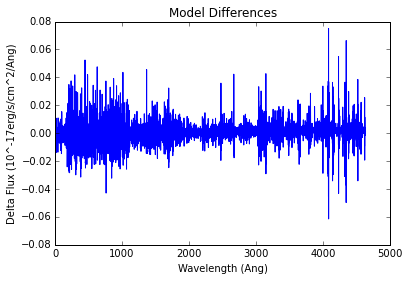

In [197]:
plt.plot(test_model-model)
plt.title('Model Differences')
plt.xlabel('Wavelength (Ang)')
plt.ylabel('Delta Flux (10^-17erg/s/cm^2/Ang)')
plt.show()

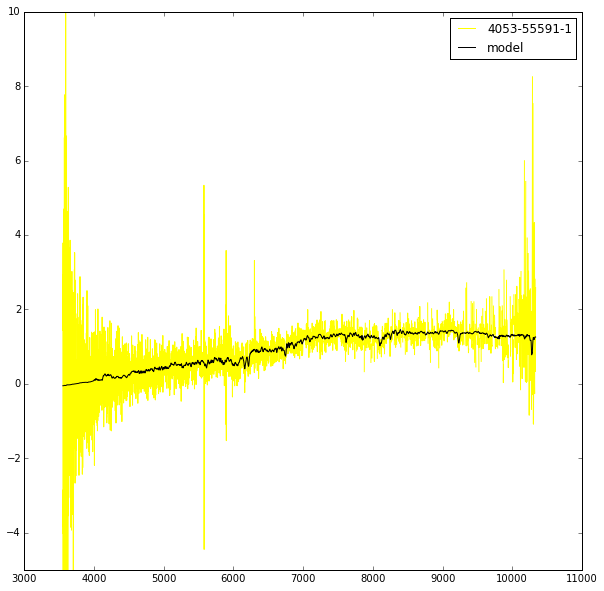

In [65]:
plt.figure(figsize = (10,10))
plt.plot(wlen, flux, color = 'yellow', label = '{}-{}-{}'.format(p, m, f))
plt.plot(wlen, test_model, color = 'black', label = 'model')
plt.legend()
plt.ylim((-5,10))
plt.show()

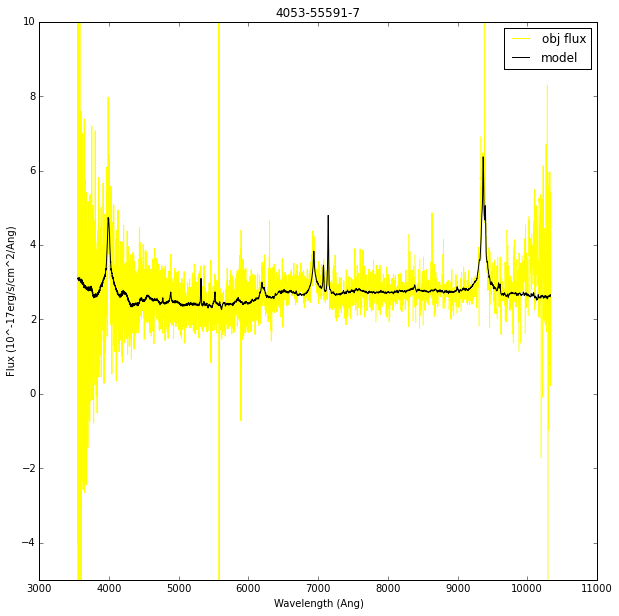

In [172]:
plt.figure(figsize = (10,10))
plt.plot(wlen, flux, color = 'yellow', label = 'obj flux')
plt.plot(wlen, test_model, color = 'black', label = 'model')
plt.title('{}-{}-{}'.format(p, m, f))
plt.legend()
plt.xlabel('Wavelength (Ang)')
plt.ylabel('Flux (10^-17erg/s/cm^2/Ang)')
plt.ylim((-5,10))
plt.show()

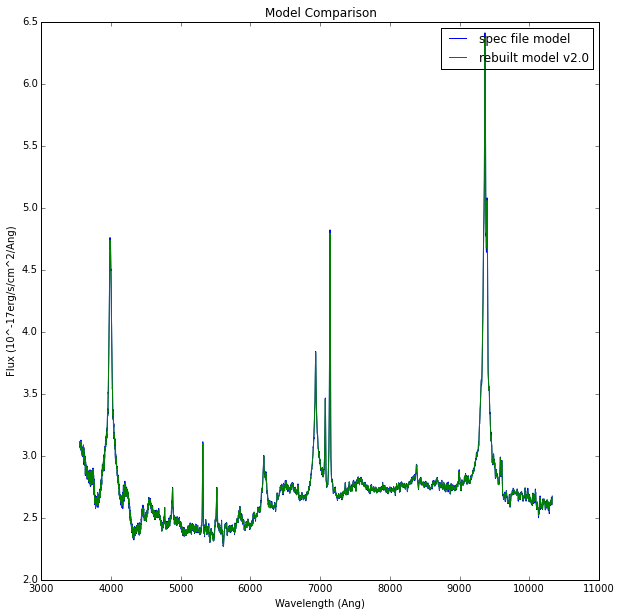

In [136]:
plt.figure(figsize = (10,10))
plt.plot(wlen, model, label = 'spec file model')
plt.plot(wlen, test_model, label = 'rebuilt model v2.0')
plt.title('Model Comparison')
plt.legend()
plt.xlabel('Wavelength (Ang)')
plt.ylabel('Flux (10^-17erg/s/cm^2/Ang)')
plt.show()

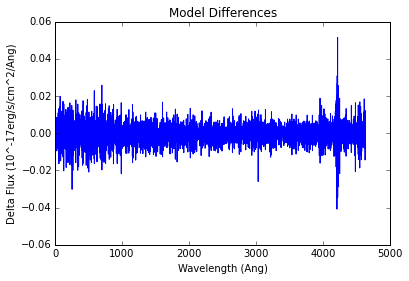

In [138]:
plt.plot(test_model-model)
plt.title('Model Differences')
plt.xlabel('Wavelength (Ang)')
plt.ylabel('Delta Flux (10^-17erg/s/cm^2/Ang)')
plt.show()